## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
from pathlib import Path

if os.name == 'nt':
    PATH = str(Path.home()) + "\\Development\\kaggle\\dogscats\\data\\"
else:
    PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True)

In [4]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [5]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.freeze_to(-4)

In [9]:
m[-1].trainable

True

In [10]:
m[-4].trainable

True

In [11]:
%time learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.20128  0.14294  0.98912]                                                                                  

Wall time: 1min 7s


In [12]:
%time learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.08377  0.0869   0.99169]                                                                                  

Wall time: 1min 6s


## CAM

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [14]:
x,y = next(iter(data.val_dl))
x,y = x[None,1], y[None,1]

vx = Variable(x.cuda(), requires_grad=True)

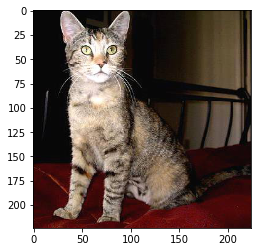

In [15]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [16]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([ 1.,  0.], dtype=float32)

In [17]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [18]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[ 0.25924,  0.48015,  0.54014,  0.43136,  0.25269,  0.0953 ,  0.     ],
       [ 0.44601,  0.7993 ,  0.90494,  0.73979,  0.45993,  0.19785,  0.03981],
       [ 0.50123,  0.87891,  1.     ,  0.84568,  0.55693,  0.25309,  0.06047],
       [ 0.46286,  0.79099,  0.88693,  0.77325,  0.54498,  0.26694,  0.06909],
       [ 0.4145 ,  0.69875,  0.77979,  0.70491,  0.52463,  0.2769 ,  0.07156],
       [ 0.29875,  0.52551,  0.59214,  0.54176,  0.40894,  0.21444,  0.05214],
       [ 0.12277,  0.24892,  0.29598,  0.27374,  0.19539,  0.09326,  0.00567]], dtype=float32)

c:\users\klukas\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


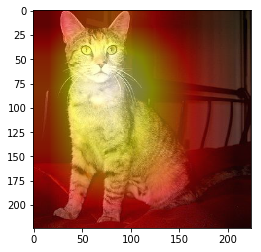

In [19]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [20]:
learn.unfreeze()
learn.bn_freeze(True)

In [21]:
lr=np.array([1e-6,1e-4,1e-2])

In [22]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.06725  0.08659  0.9913 ]                                                                                  
[ 1.       0.05468  0.08545  0.99169]                                                                                  

Wall time: 3min 44s


In [23]:
%time log_preds_augmented,y = learn.TTA()
log_preds = log_preds_augmented.mean(axis=0)
accuracy(log_preds, y)

Wall time: 1min                                                                                                        


0.993430220983476

In [24]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.09087  0.08553  0.99209]                                                                                  
[ 1.       0.08715  0.0871   0.9913 ]                                                                                  

Wall time: 3min 42s


In [25]:
%time log_preds_augmented,y = learn.TTA()
log_preds = log_preds_augmented.mean(axis=0)
accuracy(log_preds, y)

Wall time: 1min                                                                                                        


0.99323113677085406